# Single-Cell Preprocessing

This file provides preprocessing as is standard in single cell preprocessing roughly following:

M.D. Luecken, F.J. Theis, "Current best practices in single-cell RNA-seq analysis: a tutorial", Molecular Systems Biology 15(6) (2019): e8746



In [3]:
import scanpy as sc
import scirpy as ir

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from matplotlib import rcParams

## Paths

We want to save intermediate preprocessing results, so that we can start from this point later. 

In [4]:
path_base = './data/raw_data/thymus_annotated_matrix_files/HTA08.v01.A06.Science_human_tcells.h5ad'
path_filtered = './data/01_filtered_data.h5ad'
path_normalized = './data/02_normalized_data.h5ad'
path_high_var = './data/03_variableGenes_data.h5ad'
path_tcr = './data/04_merged_data.h5ad'
path_tcr_filtered = './data/05_tcr_filtered_data.h5ad'
path_tcr_anno = './data/06_tcr_annotation_data.h5ad'
path_tcr_anno_with_gender = './data/07_tcr_annotation_with_gender_data.h5ad'
path_tcr_anno_A_B = './data/08_tcr_annotation_A_B_data.h5ad'
path_tcr_anno_A_B_with_gender = './data/09_tcr_annotation_A_B_with_gender_data.h5ad'

#I changed double dot with one dot above
#A single dot means that the module or package referenced is in the same directory as the current location.
#Two dots mean that it is in the parent directory of the current location, in other words the directory above.
#Set your current directory accordingly! See below.

In [5]:
import os
os.chdir('C:/Users/Gheorghe Pascu/OneDrive - tum.de/WiSe 21-22/Computational_Methods_in_Single_Cell_Biology/T_cell_project/') # where the folder 'data' can be found
cwd = os.getcwd()
#print(cwd)

## Reading adata Object
The data is stored in an annotated data object (https://anndata.readthedocs.io/en/latest/) with .h5ad extension. We use Scanpy (https://scanpy.readthedocs.io/en/stable/) to load the data.

In [4]:
adata = sc.read_h5ad(path_base)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
print(adata.obs.head(5))

                                     Sample donor organ sort method  \
index                                                                 
FCAImmP7179369-AAACCTGAGCCCAATT  F21_TH_45P   F21    TH  45P   3GEX   
FCAImmP7179369-AAACCTGAGCCTATGT  F21_TH_45P   F21    TH  45P   3GEX   
FCAImmP7179369-AAACCTGAGTCGCCGT  F21_TH_45P   F21    TH  45P   3GEX   
FCAImmP7179369-AAACCTGCAGCATGAG  F21_TH_45P   F21    TH  45P   3GEX   
FCAImmP7179369-AAACCTGGTCTCCCTA  F21_TH_45P   F21    TH  45P   3GEX   

                                           file  is_TRA_p  is_TRB_p  \
index                                                                 
FCAImmP7179369-AAACCTGAGCCCAATT  FCAImmP7179369     False     False   
FCAImmP7179369-AAACCTGAGCCTATGT  FCAImmP7179369     False     False   
FCAImmP7179369-AAACCTGAGTCGCCGT  FCAImmP7179369     False     False   
FCAImmP7179369-AAACCTGCAGCATGAG  FCAImmP7179369     False     False   
FCAImmP7179369-AAACCTGGTCTCCCTA  FCAImmP7179369     False     False   

    

In [203]:
print('Amount cells: ', adata.X.shape[0])
print('Amount genes: ', adata.X.shape[1])

Amount cells:  76994
Amount genes:  33694


In [204]:
print('Annotations per Cell: ')
adata.var_names_make_unique()
adata.obs.head(5)

Annotations per Cell: 


,Sample,donor,organ,sort,method,file,is_TRA_p,is_TRB_p,is_TRA_np,is_TRB_np,Age,Source,cell types
index,,,,,,,,,,,,,
FCAImmP7179369-AAACCTGAGCCCAATT,F21_TH_45P,F21,TH,45P,3GEX,FCAImmP7179369,False,False,False,False,16w,HDBR,CD8+T
FCAImmP7179369-AAACCTGAGCCTATGT,F21_TH_45P,F21,TH,45P,3GEX,FCAImmP7179369,False,False,False,False,16w,HDBR,CD4+T
FCAImmP7179369-AAACCTGAGTCGCCGT,F21_TH_45P,F21,TH,45P,3GEX,FCAImmP7179369,False,False,False,False,16w,HDBR,DP(P)
FCAImmP7179369-AAACCTGCAGCATGAG,F21_TH_45P,F21,TH,45P,3GEX,FCAImmP7179369,False,False,False,False,16w,HDBR,CD8+T
FCAImmP7179369-AAACCTGGTCTCCCTA,F21_TH_45P,F21,TH,45P,3GEX,FCAImmP7179369,False,False,False,False,16w,HDBR,CD8αα(I)


## Quality Control
Due to sequencing errors / artefacts, several samples in the adata object are invalid. This might occure due to multiple cells in the same droplet (duplets), dieing cells, empty droplets, ... 

In order to filter these cells, we apply several filters on the following quantities:
- n_counts: amount of measured genes per cell
- n_genes: amount of different genes measured in a cell
- mt_frac: fraction of mitochondrial genes (high fraction indicates dieing cells)

In [206]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])

adata.obs['n_genes'] = (adata.X > 0).sum(axis=1) # (adata.X) > 0 is an array with True or False values
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names] #array with True and False entries
#var_names has the names of the genes
mt_gene_index = np.where(mt_gene_mask)[0] #comes out as a tuple, therefore the [0]
adata.obs['mt_fraction'] = adata.X[:, mt_gene_index].sum(axis=1) / adata.X.sum(axis=1)

Visualize with violin plots to understand the distributation.

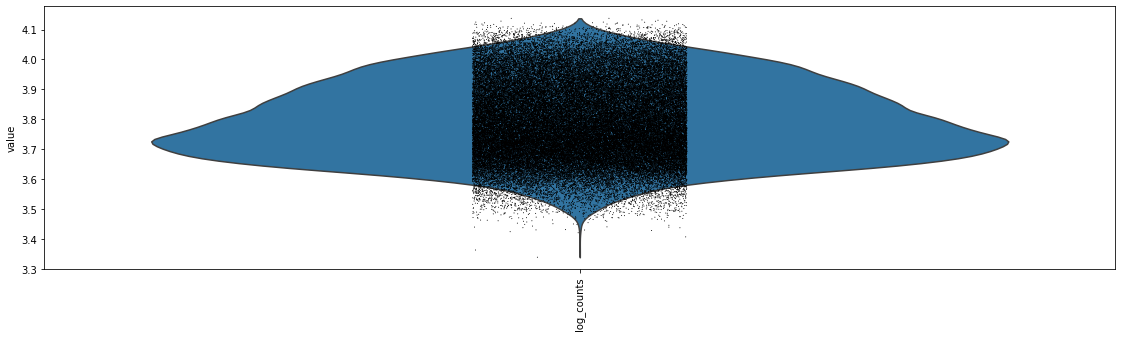

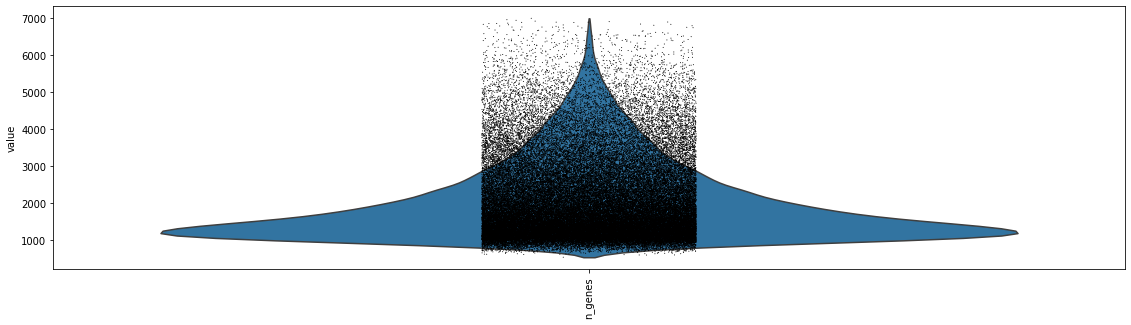

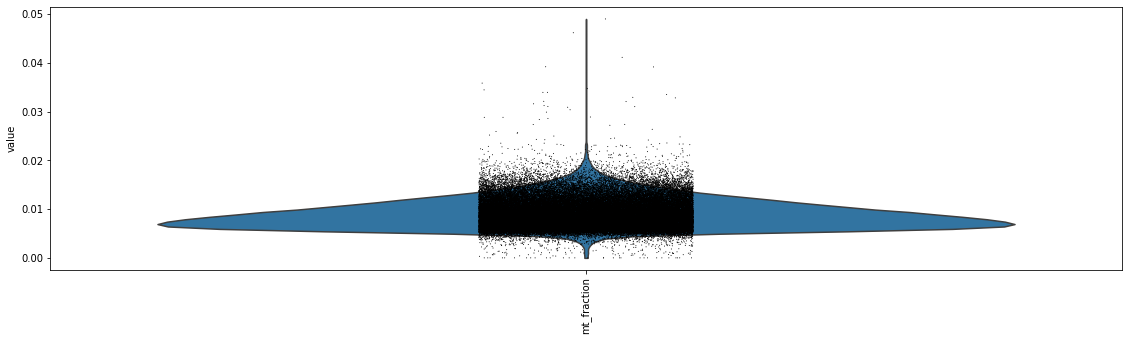

In [208]:
rcParams['figure.figsize'] = (15, 5)
sc.pl.violin(adata, ['log_counts'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['n_genes'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['mt_fraction'], size=1, log=False, rotation=90)

Joint visualisation for filtering:

<Axes:title={'center':'mt fraction'}, xlabel='n_counts', ylabel='n_genes'>

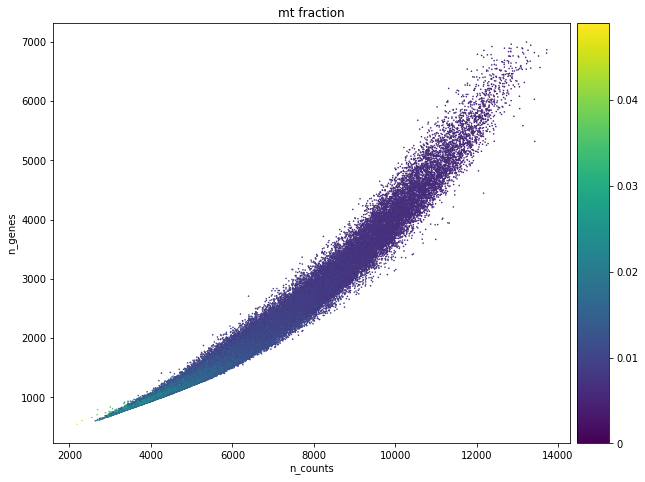

In [209]:
rcParams['figure.figsize'] = (8, 8)
sc.pl.scatter(adata, y='n_genes', x='n_counts', color='mt_fraction', size=10, show=False)

Apply Filter with values from paper / "standard" values:
(This is not very sensible, since the dataset is already "cleaned". However, it shows how this pipeline would typically be applied to a novel dataset.

In [210]:
print('Number of cells: ', len(adata))
mask_mt = adata.obs['mt_fraction'] < 0.2  # Only kepp cells with mt fraction smaller than 0.2
adata = adata[mask_mt]
print('Number of cells after mt-filter: ', len(adata))

Number of cells:  76994
Number of cells after mt-filter:  76994


C:\Users\Gheorghe Pascu\anaconda3\envs\thymusTCRs\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [211]:
adata = adata[adata.obs['n_genes']>500]
print('Number of cells after low gene filter: ', len(adata))
adata = adata[adata.obs['n_genes']<7000]
print('Number of cells after high gene filter: ', len(adata))

Number of cells after low gene filter:  76994
Number of cells after high gene filter:  76994


C:\Users\Gheorghe Pascu\anaconda3\envs\thymusTCRs\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\Gheorghe Pascu\anaconda3\envs\thymusTCRs\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [212]:
adata = adata[adata.obs['n_counts']>2000]
print('Number of cells after low count filter: ', len(adata))

Number of cells after low count filter:  76994


C:\Users\Gheorghe Pascu\anaconda3\envs\thymusTCRs\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [213]:
sc.write(adata=adata, filename=path_filtered)

## Normalization
To account for different amount of count detected for each cell, we normalize the counts to 10000. Most algorithms are performed not on raw counts but on log1p transformed values

In [214]:
adata = sc.read(path_filtered)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.write(adata=adata, filename=path_normalized)

## Highly Variable Genes
Many genes are not particualary interesting, when they occur in all cells in the dataset. Therefore, we reduce the dataset to contain only the 5000 genes, that are the most variable.

In [215]:
adata = sc.read(path_normalized)
print('Shape before Highly Variable Gene selection', adata.shape)
sc.pp.highly_variable_genes(adata, n_top_genes=5000)
adata = adata[:, adata.var['highly_variable']]
print('Shape after Highly Variable Gene selection', adata.shape)
sc.write(adata=adata, filename=path_high_var)

Shape before Highly Variable Gene selection (76994, 33694)
Shape after Highly Variable Gene selection (76994, 5000)


## Merge with TCR data

The adata object contains only the scRNA data (transcriptome) for each cell. We need to fuse that with the TCR data from folder '../data/raw_data/thymus_paper_vdj'. 
Hint:
- Use scirpy (https://icbi-lab.github.io/scirpy/latest/) an extension of scanpy for TCR analysis
- Use the description of the dataset from (https://zenodo.org/record/5500511#.YYqg67oxkUE) 
- Use 'sample_metadata_fix.xlsx' for matching the experiments between scRNA and tcr
- Have a look on the barcodes in both dataset (adata_rna.index, adata_tcr.index) and transform them to the same format

In [6]:
import os
from glob import glob
#from multiprocessing import Pool

adata_rna = sc.read(path_high_var)

In [7]:
paths = glob("./data/raw_data/thymus_paper_vdj/FCA*") + glob("./data/raw_data/thymus_paper_vdj/T0*")
#print(paths)
metadata = pd.read_excel('./data/raw_data/sample_metadata_fix.xlsx', header = 1)
metadata.set_index('FileName', inplace = True)
#print(metadata)
print(adata_rna.shape)

(76994, 5000)


In [8]:
def rename(index):
    return(index.split('-')[0] + '-' + index.split('-')[1])
def _load_adata(path):
    VDJ_filename = path.split('\\')[1]
    #VDF_file name is not same with the index. 
    #Here: identify the index corresponding to the VDJ_file name obtained from the path
    sample_id = metadata.index[metadata['VDJ_file'] == VDJ_filename]
    sample_id = sample_id[0]
    adata_tcr = ir.io.read_10x_vdj(''.join([path, "/filtered_contig_annotations.csv"]))
    adata_tcr.obs_names = [
        "{}-{}".format(sample_id, barcode) for barcode in adata_tcr.obs_names
    ]
    adata_tcr.obs.index = adata_tcr.obs.index.map(rename) # Change index name format so that it matches the one from adata_rna
    ir.pp.merge_with_ir(adata_rna, adata_tcr)

In [36]:
# Merge the adata_tcr obtained from thymus_paper_vdj files one by one into adata_rna
for i in range(len(paths)):
    _load_adata(paths[i])

... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical
... storing 'multi_chain' as categorical
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
...

In [38]:
print(adata_rna.shape)
# Have a look at those who have immune receptors
print(adata_rna.obs[adata_rna.obs['has_ir']=='True']) 

In [39]:
sc.write(adata=adata_rna, filename=path_tcr)

## TCR filter
For applying mvTCR only cells with exactly 1 TCRalpha and 1 TCRbeta chains can be used. Therefore, we need to filter out the incomplete cells.

In [9]:
#https://icbi-lab.github.io/scirpy/latest/generated/scirpy.tl.chain_qc.html#scirpy.tl.chain_qc

adata = sc.read(path_tcr)
# TODO: filter the adata_object to contain exactly one single TCR
# and save to adata object 05

In [ ]:
# See https://icbi-lab.github.io/scirpy/latest/generated/scirpy.tl.chain_qc.html#scirpy.tl.chain_qc
ir.tl.chain_qc(adata, inplace = True)

In [27]:
# Do the filtering. We need only those receptors who have a unique alpha (TRA) and a unique betha (TRB) chain (so no multichains)
adata = adata[adata.obs['receptor_subtype'] == 'TRA+TRB']
adata = adata[adata.obs['chain_pairing'] != 'multichain']

C:\Users\Gheorghe Pascu\anaconda3\envs\thymusTCRs\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [ ]:
print(adata.obs.shape) #19737 out of 76994

In [28]:
sc.write(adata=adata, filename=path_tcr_filtered)

## TCR Annotation
mvTCR requires a specific annotation for each cells. Hint:
- Use the preprocessing scripts from (https://github.com/SchubertLab/mvTCR)
- Use the functions provided in tcr_embedding.utils_preprocessing

In [6]:
adata = sc.read(path_tcr_filtered)
# TODO: annotate the TCR data so it can be used by mvTCR
# and save to adata object 06
import sys
sys.path.insert(0, '../mvTCR/tcr_embedding')
import utils_preprocessing as utils

In [7]:
#Have a look at the column names
adata.obs.columns

Index(['Sample', 'donor', 'organ', 'sort', 'method', 'file', 'is_TRA_p',
       'is_TRB_p', 'is_TRA_np', 'is_TRB_np', 'Age', 'Source', 'cell types',
       'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'multi_chain',
       'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus',
       'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3',
       'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt',
       'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr',
       'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw',
       'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene',
       'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene',
       'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene',
       'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene',
       'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene',
       'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene',
       'IR_VJ_1_junction_ins', 'IR_VJ_2_ju

In [8]:
# Create 'TRA+TRB' and 'clonotype' columns
adata.obs['TRA+TRB'] = adata.obs['IR_VJ_1_cdr3'].astype(str) + '+' + adata.obs['IR_VDJ_1_cdr3'].astype(str)
clono_dict = {clone: idx for idx, clone in enumerate(adata.obs['TRA+TRB'].unique())}
adata.obs['clonotype'] = adata.obs['TRA+TRB'].map(clono_dict)
print(len(adata.obs['clonotype'].unique()))
adata.obs['clonotype'].head()

18978


index
FCAImmP7292030-AAACCTGGTACAGACG    0
FCAImmP7292030-AAACCTGGTACATCCA    1
FCAImmP7292030-AAACCTGGTCCATCCT    2
FCAImmP7292030-AAACCTGGTGTTGGGA    3
FCAImmP7292030-AAACCTGTCCCTTGTG    4
Name: clonotype, dtype: int64

In [9]:
# Need to do it one more time apparently..

adata.obs['TRA+TRB'] = adata.obs['IR_VJ_1_cdr3'].astype(str) + '+' + adata.obs['IR_VDJ_1_cdr3'].astype(str)

In [10]:
adata = adata[adata.obs['IR_VJ_1_cdr3'] != 'None'] #These two lines are added by Petru. Avoid the None's.
adata = adata[adata.obs['IR_VDJ_1_cdr3'] != 'None']
adata.obs['TRA+TRB'] = adata.obs['IR_VJ_1_cdr3'].astype(str) + '+' + adata.obs['IR_VDJ_1_cdr3'].astype(str)
pad = adata.obs['TRA+TRB'].str.len().max()
pad = int(pad)
pad

C:\Users\Gheorghe Pascu\anaconda3\envs\thymusTCRs\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


43

In [11]:
adata.obs.columns

Index(['Sample', 'donor', 'organ', 'sort', 'method', 'file', 'is_TRA_p',
       'is_TRB_p', 'is_TRA_np', 'is_TRB_np', 'Age', 'Source', 'cell types',
       'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'multi_chain',
       'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus',
       'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3',
       'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt',
       'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr',
       'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw',
       'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene',
       'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene',
       'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene',
       'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene',
       'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene',
       'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene',
       'IR_VJ_1_junction_ins', 'IR_VJ_2_ju

In [12]:
# Create dictionary, perform encoding.
aa_to_id = {'_': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13,
            'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '+': 21, '<': 22, '>': 23}
utils.aa_encoding(adata, read_col='TRA+TRB', ohe_col='one_hot', label_col='tcr_seq', length_col='seq_len', pad=pad, aa_to_id=aa_to_id, start_end_symbol=True)

# adata.uns['aa_to_id'] = aa_to_id
# aa_to_id

In [13]:
print(adata.obsm['tcr_seq'].shape)
print(adata.obsm['one_hot'].shape)
print(adata.uns['aa_to_id'])

(10954, 45)
(10954, 45, 24)
{'_': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '+': 21, '<': 22, '>': 23}


In [14]:
max_length_alpha = adata.obs['IR_VJ_1_cdr3'].str.len().max()
max_length_beta = adata.obs['IR_VDJ_1_cdr3'].str.len().max()
print('Alpha max length: ', adata.obs['IR_VJ_1_cdr3'].str.len().max())
print('Beta max length: ', adata.obs['IR_VDJ_1_cdr3'].str.len().max())
max_length = max(adata.obs['IR_VJ_1_cdr3'].str.len().max(), adata.obs['IR_VDJ_1_cdr3'].str.len().max())
print('Max length of both chains: ', max_length)

Alpha max length:  24
Beta max length:  26
Max length of both chains:  26


In [15]:
aa_to_id = adata.uns['aa_to_id']
utils.aa_encoding(adata, read_col='IR_VJ_1_cdr3', label_col='alpha_seq', length_col='alpha_len', pad=max_length, aa_to_id=aa_to_id, start_end_symbol=False)
utils.aa_encoding(adata, read_col='IR_VDJ_1_cdr3', label_col='beta_seq', length_col='beta_len', pad=max_length, aa_to_id=aa_to_id, start_end_symbol=False)

In [16]:
print(adata.obsm['alpha_seq'].shape)
print(adata.obsm['beta_seq'].shape)
print(np.unique(adata.obsm['alpha_seq']))
print(np.unique(adata.obsm['beta_seq']))
print(adata.uns['aa_to_id'])
print(adata.obsm['one_hot'].shape)

(10954, 26)
(10954, 26)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
{'_': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '+': 21, '<': 22, '>': 23}
(10954, 45, 24)


In [17]:
adata.obs['cell types']

index
FCAImmP7292030-AAACCTGGTACAGACG                DP(P)
FCAImmP7292030-AAACCTGTCCCTTGTG                CD4+T
FCAImmP7292030-AAACGGGTCAAGCCTA                CD4+T
FCAImmP7292030-AAACGGGTCGACGGAA                CD4+T
FCAImmP7292030-AAACGGGTCTTAACCT           T(agonist)
                                             ...    
T06_TH_TOT_5GEX_4_S12-TTTGGTTCACCAGTTA         DP(Q)
T06_TH_TOT_5GEX_4_S12-TTTGGTTCATCACAAC         CD8+T
T06_TH_TOT_5GEX_4_S12-TTTGGTTGTACTTGAC         CD8+T
T06_TH_TOT_5GEX_4_S12-TTTGTCAGTAATAGCA      CD8αα(I)
T06_TH_TOT_5GEX_4_S12-TTTGTCAGTCTTCTCG    T(agonist)
Name: cell types, Length: 10954, dtype: category
Categories (16, object): ['CD4+T', 'CD8+T', 'CD8αα(I)', 'CD8αα(II)', ..., 'Treg', 'Treg(diff)', 'αβT(entry)', 'γδT']

In [18]:
# Perform the split: train, test and validation data
# To be checked: choice of the functions arguments correct?
random_seed = 15
# Create Train-Val and Test set
train_val, test = utils.stratified_group_shuffle_split(adata.obs, stratify_col='cell types', group_col='clonotype', val_split=0.20, random_seed=random_seed)
# Split Train-Val into Train and Val set
train, val = utils.stratified_group_shuffle_split(train_val, stratify_col='cell types', group_col='clonotype', val_split=0.25, random_seed=random_seed)

100%|██████████| 16/16 [00:00<00:00, 51.31it/s]


In [19]:
print('Train Samples: ', len(train))
print('Train Ratio: ', len(train) / len(adata.obs))
print('Val Samples: ', len(val))
print('Val Ratio: ', len(val) / len(adata.obs))
print('Test Samples: ', len(test))
print('Test Ratio: ', len(test) / len(adata.obs))

Train Samples:  6565
Train Ratio:  0.5993244476903414
Val Samples:  2194
Val Ratio:  0.200292130728501
Test Samples:  2195
Test Ratio:  0.20038342158115757


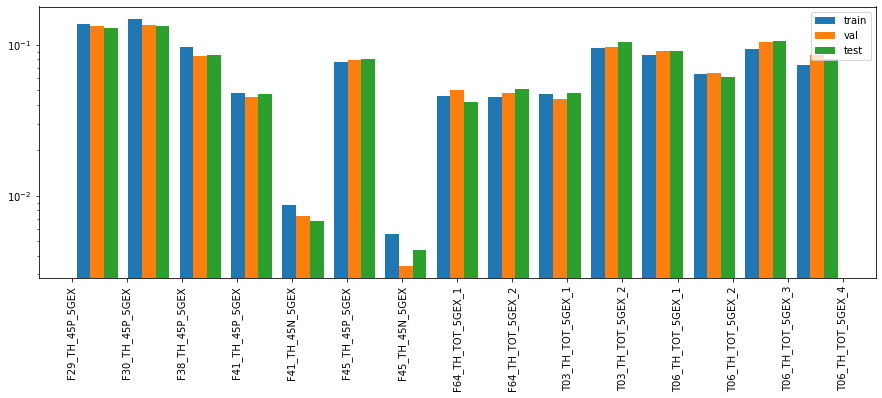

In [20]:
import matplotlib.pyplot as pl

pl.figure(figsize=(15,5))
pl.hist([train['Sample'], val['Sample'], test['Sample']], density=True, bins=len(train['Sample'].unique()), label=['train', 'val', 'test'])
pl.yscale('log')
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

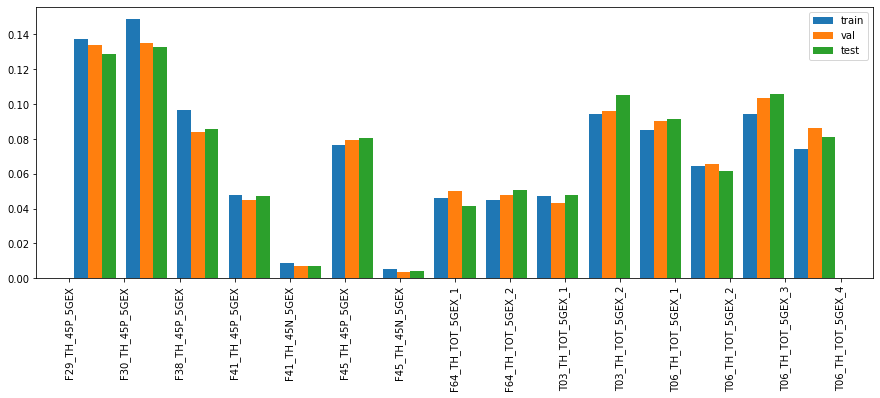

In [21]:
#Linear
pl.figure(figsize=(15,5))
pl.hist([train['Sample'], val['Sample'], test['Sample']], density=True, bins=len(train['Sample'].unique()), label=['train', 'val', 'test'])
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

In [22]:
form_train = set(train['clonotype'].tolist())
form_val = set(val['clonotype'].tolist())
form_test = set(test['clonotype'].tolist())

print('Intersection in clonotypes between two sets should be empty\n')
print('Intersection in clonotypes between train and test: ', form_train.intersection(form_test))
print('Intersection in clonotypes between train and val: ', form_train.intersection(form_val))
print('Intersection in clonotypes between val and test: ', form_val.intersection(form_test))
# print('\nSanity Check - Intersection in clonotypes between train and train: ', form_train.intersection(form_train))

Intersection in clonotypes between two sets should be empty

Intersection in clonotypes between train and test:  set()
Intersection in clonotypes between train and val:  set()
Intersection in clonotypes between val and test:  set()


In [23]:
adata.obs.loc[train.index, 'set'] = 'train'
adata.obs.loc[val.index, 'set'] = 'val'
adata.obs.loc[test.index, 'set'] = 'test'
adata.obs['set'].value_counts()

train    6565
test     2195
val      2194
Name: set, dtype: int64

In [24]:
adata.obs['set'].value_counts()['train']
# To do: run this again to see if it works cause I modeified starify col with cell type. Then no need for doing the splitting again in pickmodel.py

6565

In [25]:
sc.write(adata=adata, filename=path_tcr_anno_A_B)

... storing 'TRA+TRB' as categorical
... storing 'set' as categorical


Add 'Gender' to adata.obs

In [26]:
adata = sc.read(path_tcr_anno_A_B)

In [27]:
metadata = pd.read_excel('./data/raw_data/sample_metadata_fix.xlsx', header = 1)
metadata.set_index('FileName', inplace = True)

C:\Users\GHEORG~1\AppData\Local\Temp/ipykernel_26776/3967576174.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  metadata = pd.read_excel('./data/raw_data/sample_metadata_fix.xlsx', header = 1)


In [28]:
adata.obs['Gender'] = [None]*adata.shape[0]
for i in range(metadata.shape[0]):
    where = np.where(adata.obs['Sample'] == metadata['Sample'][i])
    if len(where[0]) != 0:
        adata.obs['Gender'][where[0]] = metadata['Gender'][i]
    #where[0] because "where" comes out as a tuple

C:\Users\GHEORG~1\AppData\Local\Temp/ipykernel_26776/1445208970.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['Gender'][where[0]] = metadata['Gender'][i]


In [29]:
sc.write(adata=adata, filename=path_tcr_anno_A_B_with_gender)

... storing 'Gender' as categorical
